In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import transforms#,datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import time

config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'

img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor


def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    print("transforming image")
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    print("Transformation done")
    
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    
    # run inference on the model and get detections
    print("Starting inference")
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    print("inference finished")

    return detections[0]


# load image and get detections
def find_object(object_name,img,selection='object_only',visualize=False, style='line'):
    prev_time = time.time()
    object_found=False
    #Detecting objects
    detections = detect_image(img)

    inference_time = datetime.timedelta(seconds=time.time() - prev_time)
    
    object_dict={}
    
    if detections is not None:
        start_time = time.time()
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)

        #converting the image to numpy array
        img = np.array(img)
        
        pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
        pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
        unpad_h = img_size - pad_y
        unpad_w = img_size - pad_x
        
        if visualize==True:
            cmap = plt.get_cmap('tab20b')
            colors = [cmap(i) for i in np.linspace(0, 1, 20)]
            bbox_colors = random.sample(colors, n_cls_preds)
            plt.figure()
            fig, ax = plt.subplots(1, figsize=(12,9))
            ax.imshow(img)

        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            if selection=='object_only' and classes[int(cls_pred)]!=object_name:
                continue
            else:
                object_found=True
                
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]

            if visualize==True:
                color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
                if style=='box':
                    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
                else:
                    bbox = patches.Rectangle((x1, y1+box_h), box_w, 0, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(bbox)
                plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',bbox={'color': color, 'pad': 0})

            object_dict[classes[int(cls_pred)]]=(classes[int(cls_pred)],((x1+box_h).item(),(y1).item()),((x1+box_h+box_w).item(),(y1).item()))
            if object_found:
                break
            
        if visualize==True:
            plt.axis('off')
            plt.show()
    return object_dict

    

Matplotlib created a temporary config/cache directory at /home/jetbot/.cache/matplotlib because the default path (/tmp/matplotlib-xzdqocsd) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
img_path = "test.jpeg"
img = Image.open(img_path)
width, height = img.size  
start_time = time.time()
object_dict=find_object('cup',img,'object_only',False)
print("--- %s seconds to get coordinates  ---" % (time.time() - start_time))
print(object_dict)

transforming image
Transformation done
Starting inference
inference finished
--- 11.770724773406982 seconds to get coordinates  ---
{}


transforming image
Transformation done
Starting inference
inference finished


<Figure size 432x288 with 0 Axes>

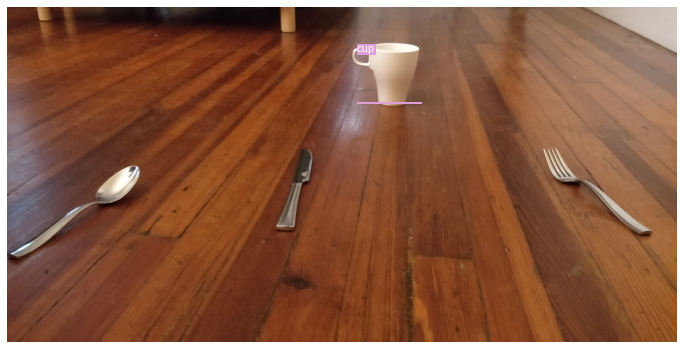

--- 9.607198238372803 seconds to get coordinates  ---
{'cup': ('cup', (2812.72021484375, 251.59461975097656), (3261.05322265625, 251.59461975097656))}


In [3]:
img_path = "images/utensils1.jpg"
img = Image.open(img_path)
width, height = img.size  
start_time = time.time()
object_dict=find_object('cup',img,'object_only',True)
print("--- %s seconds to get coordinates  ---" % (time.time() - start_time))
print(object_dict)

transforming image
Transformation done
Starting inference
inference finished


<Figure size 432x288 with 0 Axes>

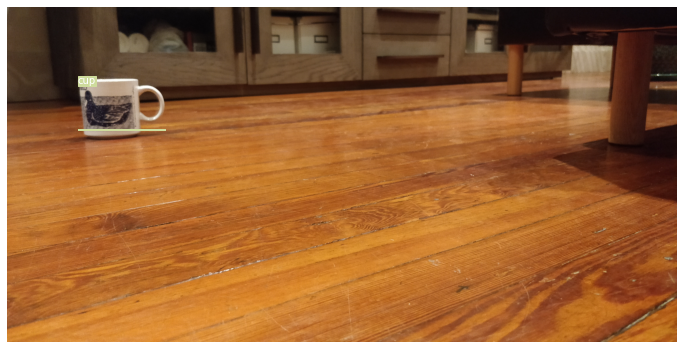

--- 9.715945482254028 seconds to get coordinates  ---
{'cup': ('cup', (855.6378173828125, 476.2490539550781), (1462.6558837890625, 476.2490539550781))}


In [4]:
img_path = "images/utensils2.jpg"
img = Image.open(img_path)
width, height = img.size  
start_time = time.time()
object_dict=find_object('cup',img,'object_only',True)
print("--- %s seconds to get coordinates  ---" % (time.time() - start_time))
print(object_dict)

transforming image
Transformation done
Starting inference
inference finished


<Figure size 432x288 with 0 Axes>

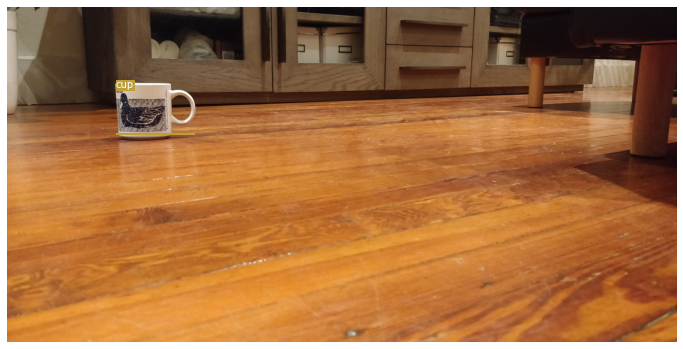

--- 10.51288890838623 seconds to get coordinates  ---
{'cup': ('cup', (1114.50341796875, 503.5619201660156), (1661.144775390625, 503.5619201660156))}


In [5]:
img_path = "images/utensils3.jpg"
img = Image.open(img_path)
width, height = img.size  
start_time = time.time()
object_dict=find_object('cup',img,'object_only',True)
print("--- %s seconds to get coordinates  ---" % (time.time() - start_time))
print(object_dict)